In [1]:
%%configure -f
{
    "conf": {
        "spark.pyspark.python": "python3",
        "spark.pyspark.virtualenv.enabled": "true",
        "spark.pyspark.virtualenv.type":"native",
        "spark.pyspark.virtualenv.bin.path":"/usr/bin/virtualenv"
    }
}

In [2]:
sc.install_pypi_package("boto3==1.19.2")
sc.install_pypi_package("pandas==1.0.5")
sc.install_pypi_package("scipy==1.4.1")
sc.install_pypi_package("matplotlib==3.2.1")
sc.install_pypi_package("seaborn==0.10.1")
sc.install_pypi_package("textblob")
sc.install_pypi_package("pyspellchecker")

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,Current session?
0,application_1685119686861_0002,pyspark,idle,Link,Link,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [3]:
df = spark.read.parquet('s3://amazon-reviews-pds/parquet/product_category=Electronics/*.parquet')

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [4]:
print(df.count())

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

3120938

In [4]:
df = df.na.drop()
print(df.count())

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

3120848

#### Response variable (Y) 

In [5]:
df = df.withColumn('vp_dummy', 
                             (df.verified_purchase == 'Y').cast("integer"))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [7]:
df.groupBy('vp_dummy').count().show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------+-------+
|vp_dummy|  count|
+--------+-------+
|       1|2622841|
|       0| 498007|
+--------+-------+

In [6]:
vp = df[df.vp_dummy == 1].count()
nvp = df[df.vp_dummy == 0].count()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

### balance dataset because two claases are not balanced

In [7]:
from pyspark.sql.functions import col
df = df.sampleBy("vp_dummy", fractions={0:1,1:nvp/vp}, seed=0)
df.groupBy("vp_dummy").count().orderBy("vp_dummy").show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------+------+
|vp_dummy| count|
+--------+------+
|       0|498007|
|       1|497877|
+--------+------+

In [10]:
df.columns

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

['marketplace', 'customer_id', 'review_id', 'product_id', 'product_parent', 'product_title', 'star_rating', 'helpful_votes', 'total_votes', 'vine', 'verified_purchase', 'review_headline', 'review_body', 'review_date', 'year', 'vp_dummy']

### feature engineering

In [8]:
from pyspark.sql.functions import udf
from pyspark.sql.types import IntegerType
from spellchecker import SpellChecker
import string

# Assuming you have a DataFrame 'df' with a 'review' column

spell = SpellChecker()

def spelling_errors(text):
    if text is None:
        return None
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    misspelled = spell.unknown(text.split())
    return len(misspelled)

count_errors_udf = udf(spelling_errors, IntegerType())

# Apply the UDF to the 'review' column
df = df.withColumn("spelling_errors", count_errors_udf(df['review_body']))


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [9]:
from textblob import TextBlob
from pyspark.sql.types import FloatType
from pyspark.sql.functions import udf

# Assuming you have a DataFrame 'df' with a 'review' column


# Define a UDF to calculate sentiment polarity
def sentiment_analysis(text):
    return TextBlob(text).sentiment.polarity

sentiment_analysis_udf = udf(sentiment_analysis, FloatType())

# Apply the UDF to the 'review' column
df = df.withColumn("sentiment_score", sentiment_analysis_udf(df['review_body']))


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [10]:
df = df.withColumn('helpful_pct', 
                             (df.helpful_votes / df.total_votes)).fillna(0)



FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [11]:
import pyspark.sql.functions as F
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.window import Window

#Length of Review
df = df.withColumn('review_length', F.length("review_body"))
# 1. categorical vine and verified_purchase
df = df.withColumn('v_dummy', 
                             (df.vine == 'Y').cast("integer"))


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [12]:
### one-hot encoding "marketplace" variable

from pyspark.ml.feature import StringIndexer, OneHotEncoder
from pyspark.ml import Pipeline

# First index the string column
indexer = StringIndexer(inputCol="marketplace", outputCol="marketplaceIndex")

# Then encode the indexed values to dummy variables
encoder = OneHotEncoder(inputCol="marketplaceIndex", outputCol="marketplaceVec")

# Create a pipeline to apply the transformations
pipeline = Pipeline(stages=[indexer, encoder])

# Fit and transform the data
df= pipeline.fit(df).transform(df)

df.show()


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-----------+-----------+--------------+----------+--------------+--------------------+-----------+-------------+-----------+----+-----------------+--------------------+--------------------+-----------+----+--------+---------------+---------------+------------------+-------------+-------+----------------+--------------+
|marketplace|customer_id|     review_id|product_id|product_parent|       product_title|star_rating|helpful_votes|total_votes|vine|verified_purchase|     review_headline|         review_body|review_date|year|vp_dummy|spelling_errors|sentiment_score|       helpful_pct|review_length|v_dummy|marketplaceIndex|marketplaceVec|
+-----------+-----------+--------------+----------+--------------+--------------------+-----------+-------------+-----------+----+-----------------+--------------------+--------------------+-----------+----+--------+---------------+---------------+------------------+-------------+-------+----------------+--------------+
|         US|   52826068|R3SC2T77Y

In [16]:
df.columns

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

['marketplace', 'customer_id', 'review_id', 'product_id', 'product_parent', 'product_title', 'star_rating', 'helpful_votes', 'total_votes', 'vine', 'verified_purchase', 'review_headline', 'review_body', 'review_date', 'year', 'vp_dummy', 'spelling_errors', 'sentiment_score', 'helpful_pct', 'review_length', 'v_dummy', 'marketplaceIndex', 'marketplaceVec']

In [13]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.sql.functions import regexp_replace

#selected features 
vector_assembler = VectorAssembler(inputCols=['marketplaceVec',
                                              'review_length',
                                              'v_dummy',
                                              'star_rating',
                                            'sentiment_score',
                                              'spelling_errors',
                                            'helpful_pct'],
                                   outputCol='features')


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [14]:

from pyspark.ml.classification import GBTClassifier


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [15]:

gbt_classifier = GBTClassifier(labelCol='vp_dummy',
                               featuresCol='features')



FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [16]:

pipeline2 = Pipeline(stages=[vector_assembler, gbt_classifier])


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [17]:
df = df.sample(fraction = 0.001)
train, test = df.randomSplit([0.7, 0.3])

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [18]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
# evaluator 
evaluator = BinaryClassificationEvaluator(labelCol='vp_dummy', metricName='areaUnderROC')

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [19]:
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
import numpy as np 


gbt_param_grid = ParamGridBuilder() \
    .addGrid(gbt_classifier.maxDepth, [5, 10]) \
    .addGrid(gbt_classifier.maxBins, [32, 64]) \
    .build()


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [20]:
cv2 = CrossValidator(estimator = pipeline2,
                    estimatorParamMaps = gbt_param_grid,
                    evaluator = evaluator)

# fit the cross validator
model2 = cv2.setNumFolds(5).fit(train)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [21]:
# Get the best model from cross-validation
bestModel = model2.bestModel

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [22]:
# Print the best parameters
bestParams = bestModel.stages[-1].extractParamMap()
print("Best Parameters:")
for param, value in bestParams.items():
    print(f"{param.name}: {value}")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Best Parameters:
cacheNodeIds: False
checkpointInterval: 10
featureSubsetStrategy: all
featuresCol: features
impurity: variance
labelCol: vp_dummy
leafCol: 
lossType: logistic
maxBins: 32
maxDepth: 5
maxIter: 20
maxMemoryInMB: 256
minInfoGain: 0.0
minInstancesPerNode: 1
minWeightFractionPerNode: 0.0
predictionCol: prediction
probabilityCol: probability
rawPredictionCol: rawPrediction
seed: 3504127614838123891
stepSize: 0.1
subsamplingRate: 1.0
validationTol: 0.01

In [23]:
# Make predictions on the training data
train_predictions = bestModel.transform(train)

# Make predictions
test_predictions = bestModel.transform(test)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

### Accuracy score


In [25]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Initialize evaluator
evaluator = MulticlassClassificationEvaluator(labelCol="vp_dummy", predictionCol="prediction", metricName="accuracy")

# Compute accuracy on the training data
train_accuracy = evaluator.evaluate(train_predictions)

print("Training Accuracy = %g" % (train_accuracy))
print("Training Error = %g" % (1.0 - train_accuracy))

# Compute accuracy on the testing data
test_accuracy = evaluator.evaluate(test_predictions)

print("Testing Accuracy = %g" % (test_accuracy))
print("Testing Error = %g" % (1.0 - test_accuracy))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Training Accuracy = 0.625181
Training Error = 0.374819
Testing Accuracy = 0.607973
Testing Error = 0.392027

### AUC Score

In [26]:
# Test AUC
binaryAUC = evaluator.evaluate(test_predictions)
print("Test AUC: {:.4f}".format(binaryAUC))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Test AUC: 0.6379

In [27]:
# Train AUC
train_binaryAUC = evaluator.evaluate(train_predictions)
print("Train AUC: {:.4f}".format(train_binaryAUC))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Train AUC: 0.8396

### Plot ROC curve

In [28]:
raw_predictions = test_predictions.select('vp_dummy', 'rawPrediction')

# Convert the raw prediction values to (probability, label) tuples:
convert_predictions = raw_predictions.rdd.map(lambda row: (float(row['rawPrediction'][1]), float(row['vp_dummy'])))

# Sort the predictions by probability in descending order
sorted_predictions = convert_predictions.sortBy(lambda x: x[0], ascending=False)

# Count the positive and negative instances in the test data
total_positive = sorted_predictions.filter(lambda x: x[1] == 1.0).count()
total_negative = sorted_predictions.filter(lambda x: x[1] == 0.0).count()


# Initialize variables to store the true positive rate (TPR) and false positive rate (FPR)
tpr_values = []
fpr_values = []
tp = 0
fp = 0

# Compute TPR and FPR at different probability thresholds
for prob, label in sorted_predictions.collect():
    if label == 1.0:
        tp += 1
    else:
        fp += 1
    tpr = tp / total_positive
    fpr = fp / total_negative
    tpr_values.append(tpr)
    fpr_values.append(fpr)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

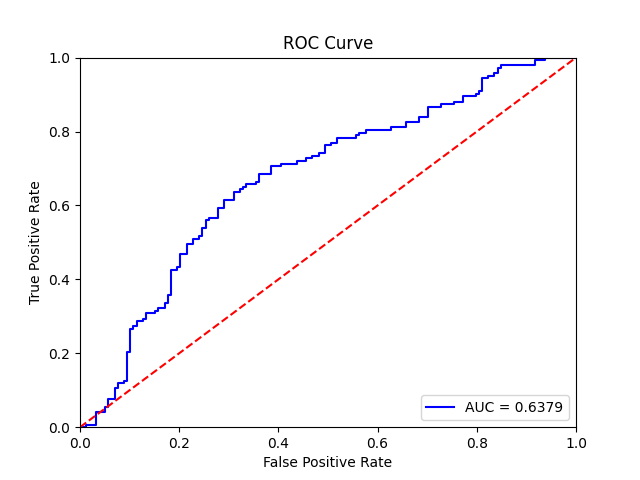

In [31]:
import matplotlib.pyplot as plt

# Plot the ROC curve
plt.plot(fpr_values, tpr_values, 'b', label = 'AUC = 0.6379')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.legend(loc = 'lower right')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

%matplot plt